In [1]:
import numpy as np
import pandas as pd

### Implemented a decision tree learner for this particular problem that can derive decision trees with an arbitrary, pre-determined depth (up to the maximum depth where all data sets at the leaves are pure) using the information gain criterion.

In [2]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

    
def create_leaf(data, ml_task):
    
    label_column = data[:, -1]
    if ml_task == "regression":
        leaf = np.mean(label_column)
        
    else:
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        leaf = unique_classes[index]
    
    return leaf

def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1): # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        unique_values = np.sort(unique_values)
        arr=[]
        for i in range(len(unique_values)-1):
            arr.append((unique_values[i] + unique_values[i+1])/2)
        unique_values = arr
        
        
        
        potential_splits[column_index] = unique_values
    
    return potential_splits


def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy


def calculate_mse(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   
        mse = 0
        
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse


def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric


def determine_best_split(data, potential_splits, ml_task):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            
            if ml_task == "regression":
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)
            
            # classification
            else:
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_entropy)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above


def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "Class":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types


def decision_tree_algorithm(df, ml_task, counter=0, min_samples=2, max_depth=5):
    
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data, ml_task)
        return leaf

    
    else:    
        counter += 1

        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits, ml_task)
        data_below, data_above = split_data(data, split_column, split_value)
        
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data, ml_task)
            return leaf
        
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        sub_tree = {question: []}
        
        yes_answer = decision_tree_algorithm(data_below, ml_task, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, ml_task, counter, min_samples, max_depth)
        

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree


def predict_example(example, tree):
    
    # tree is just a root node
    if not isinstance(tree, dict):
        return tree
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    if not isinstance(answer, dict):
        return answer
    
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

    
def make_predictions(df, tree):
    
    if len(df) != 0:
        predictions = df.apply(predict_example, args=(tree,), axis=1)
    else:

        predictions = pd.Series()
        
    return predictions


def calculate_accuracy(df, tree):
    predictions = make_predictions(df, tree)
    predictions_correct = predictions == df.Class
    accuracy = predictions_correct.mean()
    
    return accuracy

### Divided the data set into a training set comprising the first 90 data points and a test set consisting of the last 30 data elements. Used the resulting training set to derive trees of depths 1 - 8 and evaluated the accuracy of the resulting trees for the 90 training samples and for the test set containing the last 30 data items. Compared the classification accuracy on the test set with the one on the training set for each tree depth.

In [3]:
accuracy_train=[]

for i in range(1,14):

    df = pd.read_csv("data2c.csv")
    tree = decision_tree_algorithm(df.iloc[:90, :], "classification", counter=0, min_samples=1, max_depth=i)
    acct = calculate_accuracy(df.iloc[:90,:], tree)
    accuracy_train.append(acct)

In [4]:
accuracy_train

[0.7222222222222222,
 0.7333333333333333,
 0.7777777777777778,
 0.8222222222222222,
 0.8333333333333334,
 0.8444444444444444,
 0.8555555555555555,
 0.9,
 0.9444444444444444,
 0.9666666666666667,
 0.9888888888888889,
 0.9888888888888889,
 1.0]

In [5]:
accuracy=[]

for i in range(1,14):

    df = pd.read_csv("data2c.csv")
    tree = decision_tree_algorithm(df.iloc[:90, :], "classification", counter=0, min_samples=1, max_depth=i)
    acc = calculate_accuracy(df.iloc[90:,:], tree)
    accuracy.append(acc)

In [6]:
accuracy

[0.7333333333333333,
 0.7333333333333333,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8333333333333334,
 0.7666666666666667,
 0.7666666666666667,
 0.8,
 0.8,
 0.8]

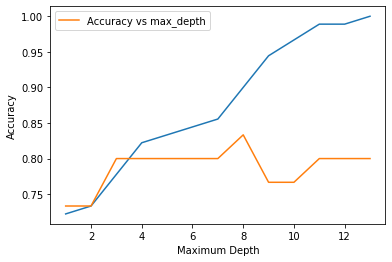

In [7]:
import matplotlib.pyplot as plt
 
max_depth_list = [i for i in range(1,14)]
x = np.arange(len(max_depth_list)) + 1 
plt.plot(x, accuracy_train)
plt.plot(x, accuracy, label='Accuracy vs max_depth') 
plt.xlabel('Maximum Depth') 
plt.ylabel('Accuracy') 
plt.legend() 
plt.show() 

#### Classification accuracy on the test vs train for each tree depth

From the above graph it can be inferred that the accuracy on the test data and train keeps on increasing with the increasing values of depth till max_depth=8. From this point the test result starts decreasing and the train results keeps on increasing which indicates the overfitting of the train data on the classifier. 

### Implemented a bagging routine for the decision tree classifier

In [8]:
df_train = df.iloc[:90, :]
df_test = df.iloc[90:, :]
actual = df_test.iloc[:, -1].values

In [9]:
def accuracy_metric(actual, predicted):
        correct = 0
        for i in range(len(actual)):
            if actual[i] == predicted[i]:
                correct += 1
        return correct / float(len(actual)) 

### Applied bagging 10, 50, and 100 times to the training data. For each of the three cases, evaluated the resulting ensemble classifier on the test data set and compared the error rates for a single classifier of the chosen depth and the three ensemble classifiers.

In [10]:
bagging=[10,50,100]
accuracy_bagging=[]
for bag in bagging:

    predictions=[]
    for i in range(bag):
        indexes = np.random.randint(low=0, high=df_train.shape[0], size=df_train.shape[0])
        dataset = df_train.iloc[indexes]
        tree = decision_tree_algorithm(dataset, "classification", counter=0, min_samples=1, max_depth=8)
        pred = make_predictions(df.iloc[90:,:-1], tree)
        predictions.append(pred.tolist())

    final_pred = []
    # prediction = []
    for j in range(len(predictions[0])): 
        count_M=0
        count_W=0
        for i in range(len(predictions)): 
            if predictions[i][j] == ' M':
                count_M = count_M + 1
            else:
                count_W = count_W + 1

        if count_M >= count_W:
            final_pred.append(" M")
        else:
            final_pred.append(" W")

    ac = accuracy_metric(actual, final_pred)
    accuracy_bagging.append(ac)

In [11]:
accuracy_bagging #For bag =10,50,100

[0.7333333333333333, 0.8333333333333334, 0.8666666666666667]

From the results it can be inferred that after applying bagging the accuracy has increased as compared to that of accuracy determined from a single classifier of depth 8 (which is the optimum depth after which the result start indicating overfitting). For Bagging value of 100, I generated 100 datasets of the same dimensions as that of actual which consist of duplicate values and ran classifier of depth 8. As a result, for the bagging part the accuracy is comparatively better than that of single classifier of the chosen depth 8. The accuracy for the single classifier of depth 8 is 0.833 where as for bagging the accuracy will change each time the code is executed as data is generated randomly and the results turn out to be better than that of result of single classifier.

### Implemented AdaBoost on top of your decision tree classifier. Applied boosting 10, 25, and 50 times to the training data. For each of the three cases, evaluated the resulting ensemble classifier on the test data set and compared the error rates for a single classifier with the chosen depth and the three ensemble classifiers.

In [ ]:
n_boosting = [10, 25, 50]

for iterations in n_boosting:

    train_data_weighted = train_data.copy()
    weights = np.ones(len(train_data)) / len(train_data)
    train_data_weighted['weight'] = weights

    trees_list = []
    alpha_list = []
    for i in range(iterations):

        tree = decision_tree_algorithm(train_data, "Classification", counter=0, min_samples=2, max_depth=5)

        test = test_data.loc[:, test_data.columns != 'weight']

        train_labels = train_data_weighted['Class'].values
        x_train = train_data_weighted.loc[:, train_data_weighted.columns != 'Class']
        x_train = x_train.loc[:, x_train.columns != 'weight']

        error_list, prediction_list = [], []
        for index, sample in x_train.iterrows():
            prediction = make_predictions(sample, tree)
            prediction_list.append(prediction[0])
            error_list.append(1 if prediction != train_labels[index] else 0)

        w = train_data_weighted['weight'].values
        epsilon = sum(w * error_list) / w.sum()

        if 0 < epsilon < 0.5:
            trees_list.append(tree)

            alpha = 0.5 * np.log((1 - epsilon) / epsilon)
            alpha_list.append(alpha)
            y = [1 if label == ' M' else -1 for label in train_labels]
            h = [1 if pred == ' W' else -1 for pred in prediction_list]
            weights = weights * np.exp(-alpha * np.asarray(y) * np.asarray(h))
            train_data_weighted['weight'] = weights

    test_labels = test_data['Class'].values
    test_labels[test_labels == ' M'] = 1
    test_labels[test_labels == ' W'] = -1

    x_test = test_data.loc[:, test_data.columns != 'Class']
    count_correct_pred = 0

    for index, sample in x_test.iterrows():
        classifications = [make_predictions(sample, tree) for tree in trees]
        classifications_int = [1 if classification == ' M' else -1 for classification in classifications]
        prediction = np.sign(sum(alpha_list * np.asarray(classifications_int)))
        if prediction == test_labels[index]:
            count_correct_pred += 1

    accuracy = count_correct_pred / len(test_labels)
